# 11. 蜡烛图形态
**用TA_Lib寻找蜡烛图特征**

## 目录
- 蜡烛图是什么？
- 蜡烛图的两大用途是什么？
- 常见蜡烛图是怎么计算的？
- 蜡烛图如何用图表显示，并用TA_Lib寻找蜡烛图？

## 蜡烛图是什么？
蜡烛图又称为K线图，主要包含四个数据，即开盘价、最高价、最低价、收盘价，所有的蜡烛图都是围绕这四个数据展开，反映大势的状况和价格信息。如果把每日的K线图放在一张图中，就能得到日K线图，同样也可画出周K线图、月K线图。

## 蜡烛图的两大用途是什么？
1. 判断反转信号
2. 判断持续信号

## 常见蜡烛图是怎么计算的？
---
### 1. 大阳线: 涨幅大于5%，上下影线小于1.8%

$Close/Open>1.05$

$High/Low < Close/Open+0.018$

---

### 2. 大阴线： 跌幅大于5%， 上下影线小于1.8%

$Open/Close > 1.05$

$High/Low < Open/Close+0.018$

---

### 3.下影线

$(Min(Close,Open)-Low)/(High-Low)>0.667$

---

### 4. 上影线
$(High-Max(Close,Open))/(High-Low)>0.667$

---

### 5.十字星
$Close-Open<Abs(0.001)$

$High-Low>0.001$

### 6. 缺口Gap
$open[-1]-close[-2]>0.01$

## http://www.stockstowatch.com/candle-indicator/

## 找出蜡烛图

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.data.hf_dataview import HFDataView

dv = HFDataView()

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

def resampleData(data, period='1H'):
    data['time'] = pd.Index(map(lambda x : datetime.strptime(x, "%Y-%m-%d %H:%M:%S") , data_excel['time']))
    data_time = data.set_index('time').dropna()
    dataResample = data_time.resample(period).agg({'high':'max','open':'first','close':'last','low':'min','volume':'sum','amount':'sum'}).dropna()
    return dataResample

data_excel = pd.read_csv(r'E:\2018_Course\AnalysisTool\HFD\bch_usdt.csv').iloc[:,1:]
data1H = resampleData(data_excel, period='30Min').iloc[-1000:]

In [6]:
data1H.head()

high       open      close        low       volume  \
time                                                                           
2018-05-06 13:30:00  1732.4312  1720.1084  1719.7192  1716.2268  1904.103792   
2018-05-06 14:00:00  1721.9828  1721.0000  1716.7006  1697.7911  1941.328075   
2018-05-06 14:30:00  1720.0000  1720.0000  1709.9000  1707.0633  1386.489791   
2018-05-06 15:00:00  1714.1466  1709.9998  1690.5646  1681.0200  2023.288676   
2018-05-06 15:30:00  1697.6875  1690.5646  1685.0000  1677.9577  1348.185114   

                           amount  
time                               
2018-05-06 13:30:00  2.088560e+07  
2018-05-06 14:00:00  2.111120e+07  
2018-05-06 14:30:00  1.512293e+07  
2018-05-06 15:00:00  2.181805e+07  
2018-05-06 15:30:00  1.447207e+07

In [7]:
def initDv(data):
    data['time'] = data.index
    data["trade_date"] = data["time"].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    data["symbol"] = "btc_usdt"
    data['usdt'] = 6.8
    data = data.set_index(["trade_date","symbol"])
    dv.create_init_dv(data) # 用来初始化dv
dataDv = data1H.copy()
initDv(dataDv)

Initialize dataview success.


## 判断低位

In [8]:
def location(df):
    Location = (df.close-df.low.rolling(50).min())/(df.high.rolling(50).max()-df.low.rolling(50).min())*100
    return Location

Location = location(data1H)

## 找出大阳线

In [35]:
import matplotlib.pyplot as plt
import matplotlib.finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.05, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume,width=0.05)
    plt.show()

In [36]:
Big_Up = dv.add_formula('Big_Up','If((close/open>1.03) && (high/low<(close/open+0.02)), 100, 0)', add_data=True)

Field [Big_Up] is overwritten.


In [37]:
dataBigUp = dv.get_ts('Big_Up', date_type='datetime')

In [38]:
scatterBigUpX = dataBigUp[dataBigUp.btc_usdt==100].index

In [39]:
scatterBigUpY = data1H.loc[scatterBigUpX].low-100

In [40]:
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

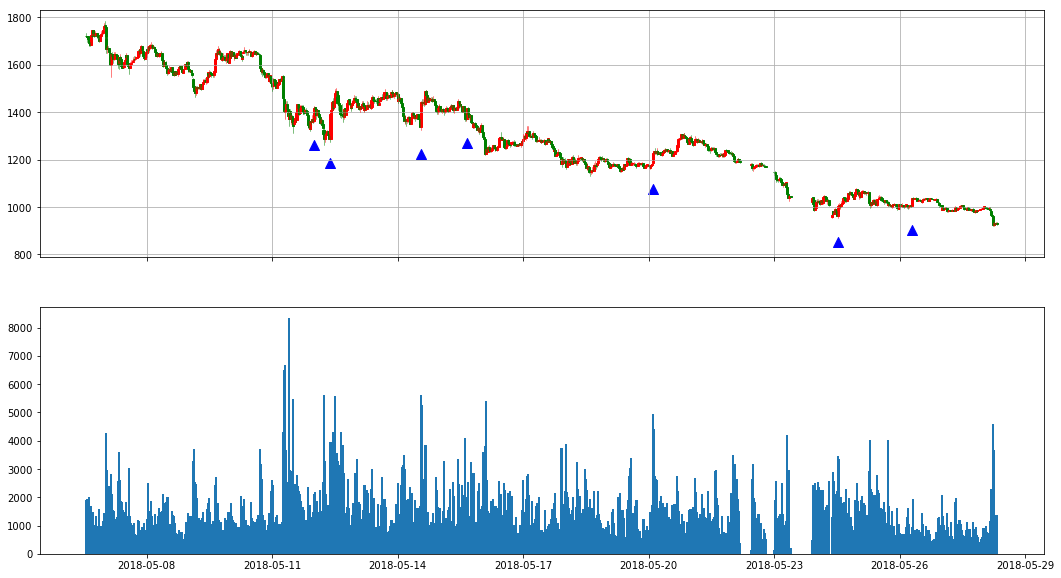

In [41]:
draw_candle(candle, scatterBigUpX, scatterBigUpY)

In [42]:
dataBigUp[dataBigUp.btc_usdt==100]

symbol               btc_usdt
trade_date                   
2018-05-12 00:00:00     100.0
2018-05-12 09:30:00     100.0
2018-05-14 13:30:00     100.0
2018-05-15 16:00:00     100.0
2018-05-20 02:30:00     100.0
2018-05-24 12:30:00     100.0
2018-05-26 07:00:00     100.0

## 找出下影线
(Min(Close,Open)-Low)/(High-Low)>0.667

In [43]:
pd.Series(list(map(lambda a,b : min(a,b), data1H['close'],data1H['open'])),index=data1H.index)

time
2018-05-06 13:30:00    1719.7192
2018-05-06 14:00:00    1716.7006
2018-05-06 14:30:00    1709.9000
2018-05-06 15:00:00    1690.5646
2018-05-06 15:30:00    1685.0000
2018-05-06 16:00:00    1685.1999
2018-05-06 16:30:00    1721.6248
2018-05-06 17:00:00    1725.6544
2018-05-06 17:30:00    1734.2857
2018-05-06 18:00:00    1722.8984
2018-05-06 18:30:00    1724.2807
2018-05-06 19:00:00    1723.9172
2018-05-06 19:30:00    1722.2782
2018-05-06 20:00:00    1716.8740
2018-05-06 20:30:00    1705.2072
2018-05-06 21:00:00    1699.7789
2018-05-06 21:30:00    1699.5557
2018-05-06 22:00:00    1720.6524
2018-05-06 22:30:00    1733.8860
2018-05-06 23:00:00    1734.7302
2018-05-06 23:30:00    1750.9997
2018-05-07 00:00:00    1757.7578
2018-05-07 00:30:00    1719.0148
2018-05-07 01:00:00    1667.9999
2018-05-07 01:30:00    1667.9999
2018-05-07 02:00:00    1665.7997
2018-05-07 02:30:00    1652.1222
2018-05-07 03:00:00    1598.8985
2018-05-07 03:30:00    1598.8985
2018-05-07 04:00:00    1637.9151
     

In [44]:
lowerShadow = dv.add_formula('lowerShadow','If(((Min(close,open)-low)/(high-low)>0.75) && (volume>Ts_Mean(volume,5)+1.32*StdDev(volume,5)),100,0)', add_data=True)

In [45]:
datalowerShadow = dv.get_ts('lowerShadow', date_type='datetime')

In [46]:
# datalowerShadow

In [47]:
scatterlowerShadowX = datalowerShadow[datalowerShadow.btc_usdt==100].index

In [48]:
scatterlowerShadowY = data1H.loc[scatterlowerShadowX].low-100

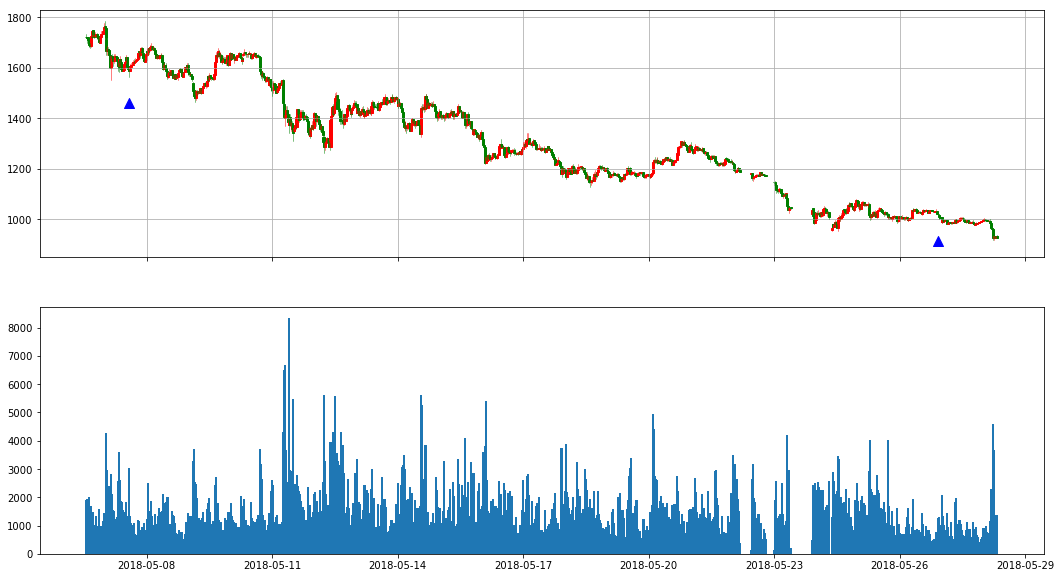

In [49]:
draw_candle(candle, scatterlowerShadowX, scatterlowerShadowY)

## 蜡烛图如何用图表显示，并用TA_Lib寻找蜡烛图？

## BullCandle
### Reversal
1. Three-line strike, bearish: 84% ta.CDL3LINESTRIKE
2. Three white soldiers: 82% ta.CDL3WHITESOLDIERS
3. Engulfing, bearish: 79% ta.CDLENGULFING
4. Morning star: 78% ta.CDLMORNINGSTAR
5. Morning doji star: 76% ta.CDLMORNINGDOJISTAR

In [22]:
engulfing = dv.add_formula('engulfing', "If((Ta('CDLENGULFING', 0, open, high, low, close, volume)==100) && (Ts_Mean(volume,2)>Ts_Mean(volume,10)+1.2*StdDev(volume,10)), 100, 0)", add_data=True)

In [23]:
engulfingVolume = dv.get_ts('engulfing', date_type='datetime')

In [24]:
engulfingVolume[engulfingVolume.btc_usdt==100]

symbol               btc_usdt
trade_date                   
2018-02-08 00:00:00     100.0
2018-02-12 08:00:00     100.0
2018-02-25 07:00:00     100.0
2018-03-01 10:00:00     100.0
2018-03-11 01:00:00     100.0
2018-03-15 06:30:00     100.0
2018-03-27 03:00:00     100.0
2018-03-28 09:00:00     100.0
2018-04-01 04:00:00     100.0
2018-04-05 11:00:00     100.0
2018-04-15 00:00:00     100.0
2018-04-24 12:00:00     100.0
2018-04-28 09:30:00     100.0
2018-04-30 22:00:00     100.0
2018-05-05 00:30:00     100.0
2018-05-18 07:00:00     100.0
2018-05-20 01:00:00     100.0

In [25]:
engulfingVolumeX = engulfingVolume[engulfingVolume.btc_usdt==100].index
engulfingVolumeY = data1H.loc[engulfingVolumeX].low-100

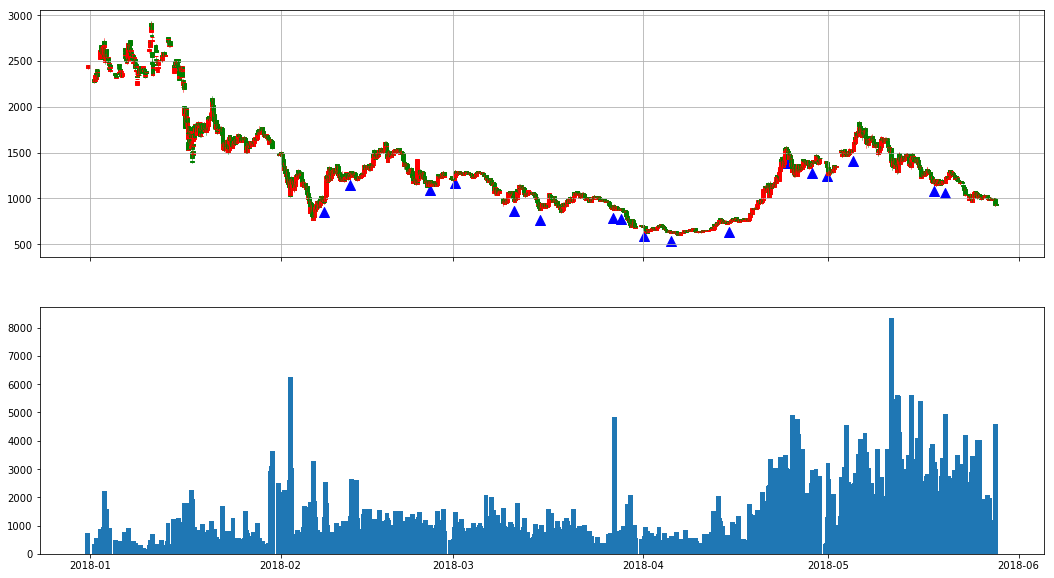

In [26]:
draw_candle(candle, engulfingVolumeX, engulfingVolumeY)

In [27]:
morningStar = dv.add_formula('morningStar', "If((Ta('CDLMORNINGSTAR', 0, open, high, low, close, volume)==100) && (Ts_Mean(volume,3)>Ts_Mean(volume,20)),100,0)", add_data=True)

In [28]:
morningStar[morningStar.btc_usdt==100]

symbol          btc_usdt
trade_date              
20180108053000     100.0
20180118090000     100.0
20180129233000     100.0
20180311040000     100.0
20180330013000     100.0
20180410233000     100.0
20180422080000     100.0

In [29]:
morningStarVolume = dv.get_ts('morningStar', date_type='datetime')

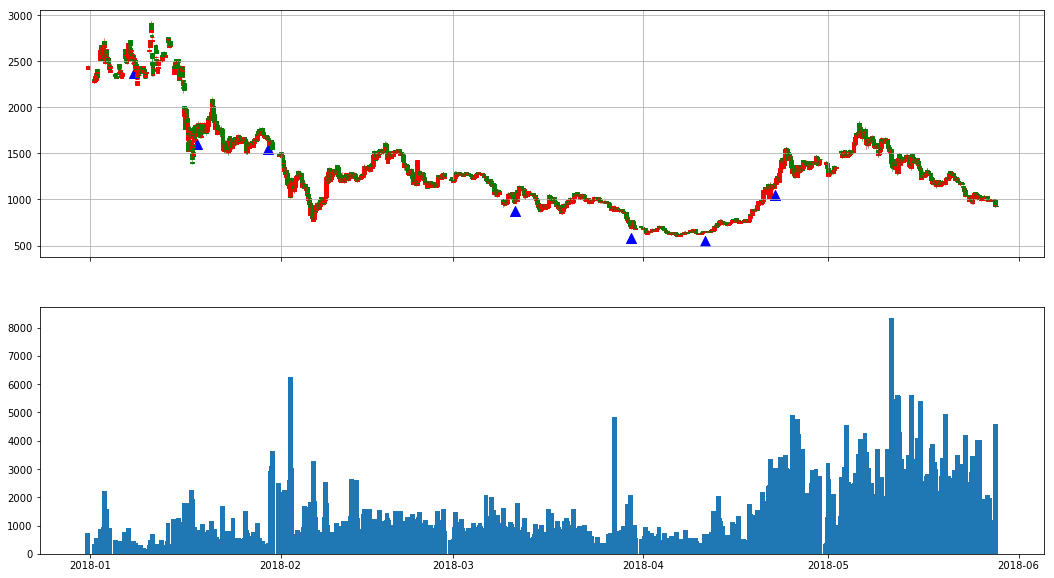

In [30]:
morningStarVolumeX = morningStarVolume[morningStarVolume.btc_usdt==100].index
morningStarVolumeY = data1H.loc[morningStarVolumeX].low-100
draw_candle(candle, morningStarVolumeX, morningStarVolumeY)

In [31]:
morningStarDv = dv.get_ts('morningStar')
engulfingDv = dv.get_ts('engulfing')
lowerShadowDv = dv.get_ts('lowerShadow')

In [32]:
morningStarDv[morningStarDv.btc_usdt==100]

symbol          btc_usdt
trade_date              
20180108053000     100.0
20180118090000     100.0
20180129233000     100.0
20180311040000     100.0
20180330013000     100.0
20180410233000     100.0
20180422080000     100.0

In [33]:
CandleSignal = morningStarDv+engulfingDv+lowerShadowDv

In [44]:
dv.append_df(CandleSignal,'CandleSignal')

In [52]:
# CandleSignalSum = dv.add_formula('CandleSignalSum','Ts_Sum(CandleSignal,10)', add_data=True)

In [51]:
# CandleSignalSum[CandleSignalSum.btc_usdt>=100]

In [80]:
long = dv.add_formula('long','If((Ts_Sum(CandleSignal,10)>=100) && (close>=Ts_Max(high,40)),2,0)', add_data=True)
# short = dv.add_formula('short','If((signalSe<=40) && (Delay(signalSe,1)>40), -2, 0)', add_data=True)
# closeLong = dv.add_formula('closeLong','close<=Ts_Mean(close,80)', add_data=True)
# closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

Field [long] is overwritten.


In [81]:
# long[long.btc_usdt==2]

In [82]:
from jaqs_fxdayu.research import TimingDigger

td = TimingDigger(output_folder=".", output_format='pdf',signal_name='Candle')

def TimingSignal(mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long/short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

TimingSignal(300, 0.5, 5)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 0%


In [83]:
td.create_event_report(sig_type="long",
                       by_symbol=True)

Figure saved: E:\2018_Course\1_Research2Strategy\Candle/long_entry_exit_position/btc_usdt.pdf
*****-Summary-*****
Event Analysis
                      win   loss    all
t-stat              2.156 -2.430  1.283
p-value             0.120  0.093  0.240
mean                0.130 -0.025  0.052
std                 0.104  0.018  0.108
info_ratio          1.245 -1.403  0.485
skewness           -0.077 -0.959  0.943
kurtosis           -1.885 -0.838 -0.838
pct5                0.010 -0.051 -0.044
pct25               0.039 -0.031 -0.016
pct50               0.139 -0.018 -0.004
pct75               0.230 -0.013  0.096
pct95               0.237 -0.011  0.235
occurance           4.000  4.000  8.000
win_ratio             NaN    NaN  0.500
win_mean/loss_mean    NaN    NaN  5.129


In [35]:
import talib as ta

threeLineStrike = ta.abstract.CDL3LINESTRIKE(data1H)
threeWhiteSoldiers = ta.abstract.CDL3WHITESOLDIERS(data1H)
engulfing = ta.abstract.CDLENGULFING(data1H)
morningStar = ta.abstract.CDLMORNINGSTAR(data1H)
morningDijiStar =  ta.abstract.CDLMORNINGDOJISTAR(data1H)

In [36]:
# engulfing

In [37]:
def getScatterXY(candlePattern):
    X = (candlePattern[candlePattern==100].index)
    Y = (data1H.loc[candlePattern==100].low-100)
    return X,Y

In [38]:
threeLineStrikeX, threeLineStrikeY = getScatterXY(threeLineStrike)
threeWhiteSoldiersX, threeWhiteSoldiersY = getScatterXY(threeWhiteSoldiers)
engulfingX, engulfingY = getScatterXY(engulfing)
morningStarX, morningStarY = getScatterXY(morningStar)
morningDijiStarX, morningDijiStarY = getScatterXY(morningDijiStar)

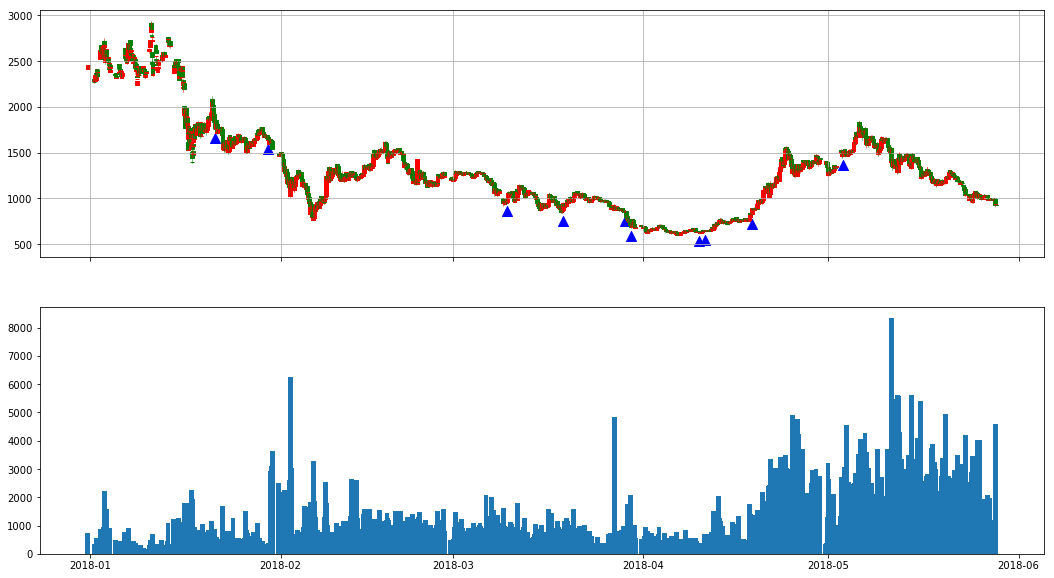

In [39]:
draw_candle(candle, morningDijiStarX, morningDijiStarY)

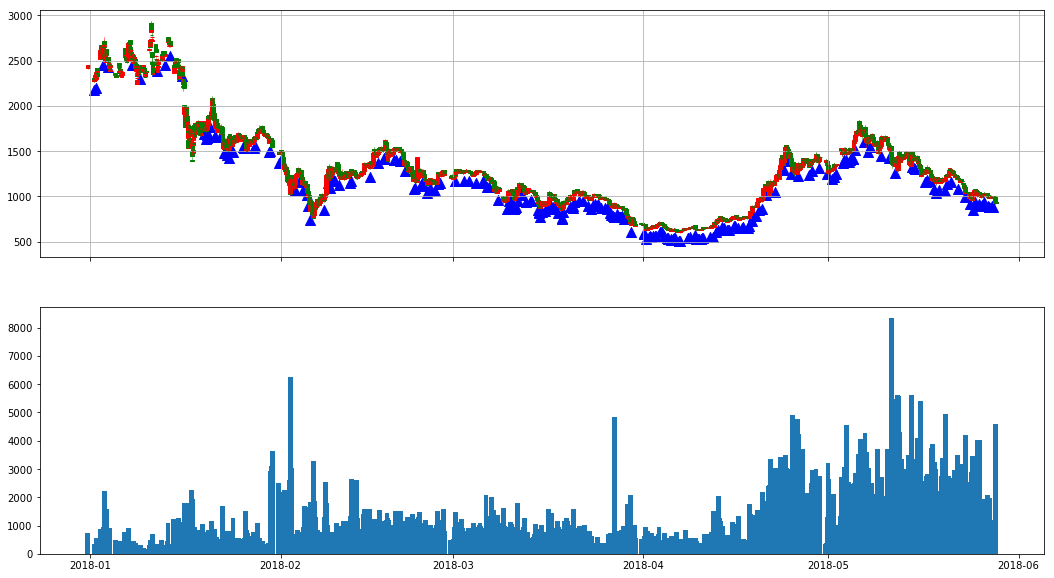

In [40]:
draw_candle(candle, engulfingX, engulfingY)

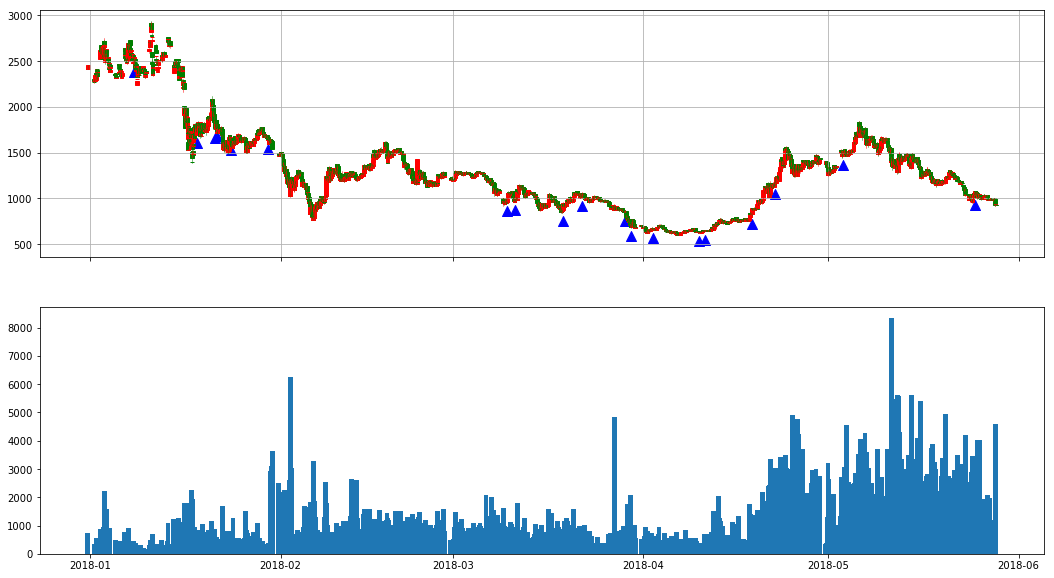

In [41]:
draw_candle(candle, morningStarX, morningStarY)